# Práctica IA en Automoviles

## Introducción

La inteligencia artificial (IA) está redefiniendo la industria automotriz, promoviendo avances significativos en seguridad, eficiencia y personalización. A través del aprendizaje automático, la visión por computadora y el procesamiento de lenguaje natural, la IA está mejorando la experiencia de conducción y transformando las operaciones de fabricación.

La personalización mejorada a través de asistentes virtuales y el mantenimiento predictivo aseguran un rendimiento óptimo del vehículo y una experiencia de usuario enriquecida. Con un valor de mercado que ya cuenta por miles de millones y un crecimiento acelerado, la IA está configurando no solo el presente sino el futuro de la industria automotriz, prometiendo una era de vehículos más inteligentes y sistemas de transporte eficientes.

A continuación, se expone el siguiente trabajo donde a partir de un dataset dado se ha de determinar una secuencia de eventos características de una maniobra de conducción. La maniobra elegida ha sido el adelantamiento pues se ha considerado que es una maniobra simple y que permite filtrar varios datos al diferenciarse bastante de las otras 4 restantes.

## Preprocesado

Antes de comenzar el entrenamiento de ningún modelo de Aprendizaje Automatizado o Machine Learning, es necesario conocer los datos empleados para este entrenamiento. En el caso de este proyecto, los datos se han obtenido por el departamento de informática de Universidad Carlos Tercero de Madrid empleando un entorno de simulación de conducción. Estos datos han sido posteriormente etiquetados por el mismo equipo, por lo que los modelos de entrenamiento que se presenta en este documento serán todos modelos de aprendizaje supervisado.

Dado que los datos para el entrenamiento de los modelos se encuentran ya etiquetados, el preprocesado de estos datos se centra en el filtrado de éstos y en obtener nuevos datos que puedan ser de mayor interés para el modelado de un sistema capaz de identificar la maniobra de adelantamiento.

En primer lugar, se realiza el filtrado de los datos que consideramos de interés, y por tanto, que son últiles para el modelo. Estos datos son:
* El momento temporal en el que se tomaron los datos
* El ángulo del volante
* La fuerza con la que se está pisando el pedal del acelerador
* La fuerza con la que se está pisando el pedal del freno
* La fuerza con la que se está pisando el pedal del embrague
* La marcha en la que se tenía el coche
* La velocidad del vehículo
* Los RPM del motor

Adicionalmente, durante este filtrado inicial guardamos la etiqueta de cada uno de estos datos. Esta etiqueta es la columna '_Maneuver marker flag_', cuyo valor se encuentra a uno cuando se está realizando un adelantamiento y toma valor cero para el resto de casos.

Una vez realizado el filtrado de los datos en bruto que se reciben, procedemos a obtener nuevos datos que suponemos que son de mayor utilidad para el entrenamiento de los modelos. Estos nuevos datos consisten principalmente en la variación de algunos de los datos filtrados a lo largo de una ventana temporal.

A partir de estos datos se decide realizar un segundo preprocesado, en esta transformación se utilizarán las variaciones en volante, acelerador, freno, embrague, etc. entre el primer y último momento que componen los veinte datos originales de un segundo.

Por otro lado, en lo que respecta al etiquetado de los nuevos datos, se ha optado por etiquetar como maniobra de adelantamiento, o lo que es lo mismo, dar valor uno en la columna del '_Maneuver marker flag_'; a todo nuevo dato en cuyo conjunto de datos originales al menos uno formaba parte de una maniobra de adelantamiento. Puesto de otra manera, todo dato nuevo producto de la segunda fase es parte de un adelantamiento si al menos uno de sus pasos contaba con valor uno en la columna del Flag de Maniobra.

Por último, agrupamos los datos de tal manera que los distintos modelos puedan recibir en su entrada los datos de un periodo de tiempo, y con ellos predecir si se está realizando un adelantamiento o no.

En esta práctica, hemos decidido que los modelos entrenados sean predictivos, es decir, predigan cuando se está realizando un adelantamiento durante el comienzo de la maniobra. Es por esto mismo, que el entrenamiento de los modelos se realizará con los datos que conforman los primeros pasos de un adelantamiento. De manera más concreta, se ha escogido que los modelos predigan si se está realizando un adelantamiento, a partir del primer segundo de la maniobra.
Adicionalmente, y con el objetivo de que los datos que se le pasan a los modelos estén balanceados, se ha optado por tomar también un único segundo de los conjuntos de datos que no conforman una maniobra.

In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_curve

from six import StringIO
import seaborn as sns

In [2]:
# Directorio base y prefijo
base_dir = 'ManiobrasSimulador'
prefix = 'STISIMData_'
fichero = 'Overtaking.xlsx'

datos = []
step = 20
preproc = []

# Maniobra data almacena todos los pasos que componen un adelantamiento
maniobra_data = []
maniobra_target = []
maniobra = []
es_maniobra = []

try:
    num_drivers = os.listdir(base_dir)
    for i, driver in enumerate(num_drivers, start=1):
        archivo = Path(base_dir) / driver / (prefix  + fichero)
        excl = pd.read_excel(archivo)

        # Realizamos un primer filtrado, para quedarnos solo con las columnas que nos interesen
        proc1 = pd.DataFrame({
            'MomentoTemporal': excl['Elapsed time'],
            'AnguloVolante': excl['Steering wheel angle'],
            'Acelerador': excl['Gas pedal'],
            'Freno': excl['Brake pedal'],
            'Embrague': excl['Clutch pedal'],
            'Marcha': excl['Gear'],
            'Velocidad': excl['speed'],
            'RPM': excl['RPM'],
            'FlagManiobra': excl['Maneuver marker flag']
        })
        #datos.append(proc1)
        var_volante = []
        var_aclrdr = []
        var_freno = []
        var_embrague = []
        var_speed = []
        var_rpm = []

        marchas_inicio = []
        marchas_fin = []
        maniobra = []
        
        arr = proc1.to_numpy()
        flag = proc1['FlagManiobra'].to_numpy()

        for i in range(0, len(proc1), step):
            segundo = arr[i:i+step-1]
            inicio = segundo[0]
            fin = segundo[-1]

            var_volante.append(fin[1] - inicio[1])
            var_aclrdr.append(int(fin[2] - inicio[2]))
            var_freno.append(int(fin[3] - inicio[3]))
            var_embrague.append(int(fin[4] - inicio[4]))
            var_speed.append(fin[6] - inicio[6])
            var_rpm.append(fin[7] - inicio[7])

            marchas_inicio.append(int(inicio[5]))
            marchas_fin.append(int(fin[5]))
            maniobra.append(int(1 in flag[i:i+step]))
        
        dts_preproc = pd.DataFrame({'VariacionVolante': var_volante,
                                'VariacionAcelerador': var_aclrdr,
                                'VariacionFreno': var_freno,
                                'VariacionEmbrague': var_embrague,
                                'VariacionVelocidad': var_speed,
                                'VariacionRPM': var_rpm,
                                'MarchaInicio': marchas_inicio,
                                'MarchaFinal': marchas_fin,
                                'Maniobra': maniobra
        })
        preproc.append(dts_preproc)
        arr = dts_preproc.to_numpy()
            
        # todos los datos excepto el de flag de maniobra que lo guardamos en maniobra_target
        es_maniobra = int(arr[0][8])
        paso = [arr[0][0], int(arr[0][1]), int(arr[0][2]), int(arr[0][3]), arr[0][4], arr[0][5],
                int(arr[0][6]), int(arr[0][7])]
        
        maniobra_data.append(paso)
        maniobra_target.append(es_maniobra)
        
        for i in range(len(arr)):
            paso = [arr[i][0], int(arr[i][1]), int(arr[i][2]), int(arr[i][3]), arr[i][4], arr[i][5],
                int(arr[i][6]), int(arr[i][7])]
            
            if es_maniobra != int(arr[i][8]):
                # si hay un cambio en maniobra añadimos el paso
                maniobra_data.append(paso)
                # si hay un cambio añadimos si es maniobra/no el actual
                maniobra_target.append(int(arr[i][8]))
            
                es_maniobra = int(arr[i][8])

except Exception as e:
    print(f"Error: {e}")

Tras el preprocesado de los datos, definimos X e y. X son los datos de entrada del modelo que representan diferentes aspectos o atributos del conjunto de datos. Por su parte, y representa la etiqueta de estos datos; si un conjunto de datos es maniobra o no. Este último conjunto se empleará tanto para el entrenamiento como para evaluar cada uno de los distintos modelos.
Ambos conjuntos están relacionados, de tal manera que para cada elemento del conjunto X le corresponde la etiqueta con el mismo índice dentro del conjunto y.

Una vez se tienen los conjuntos X e y, se reaprten los datos que los conforman entre un subconjunto de entrenamiento y otro de prueba. Se ha decido realizar la división de tal manera que un 70% de los datos correspondan al conjunto de entrenamiento y el 30% restante estén destinados al entrenamiento.

In [3]:
# Definir las características (X) y la variable objetivo (y)
X = maniobra_data
y = maniobra_target

# Dividir los datos en conjuntos de entrenamiento y prueba. 70% entrenamiento y 30% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

## Árbol de decisión

Un árbol de decisión es un método de aprendizaje supervisado no paramétrico que se utiliza para clasificación y regresión. Son modelos de predicción que aprenden a realizar decisiones basándose en los datos de entrada. El algoritmo de árbol de decisión comienza en la raíz del árbol y divide el conjunto de datos completo en subconjuntos más pequeños, mientras simultáneamente desarrolla un árbol asociado de forma incremental.

A continuación, se crea un objeto DecisionTreeClassifier() que representa el modelo de Árbol de Decisión con un random_state para obtener siempre el mismo árbol. Y se entrena el modelo con el conjunto de entrenamiento (X_train, y_train) utilizando el método fit().

Finalmente, con el modelo ya entrenado, se utiliza el conjunto de prueba (X_test) para predecir si cad muestra de prueba corresponde a un adelantamiento o no, obteniendo así las predicciones y_pred. Ahora, se calcula la precisión del modelo comparando los valores de las predicciones(y_pred) con los valores reales(y_test)

La precisión obtenida es de un 76%. Es decir, el modelo ha podido predecir correctamente la maniobra realizada en aproximadamente el 76% de los casos dentro del conjunto de prueba.

Tras esto se visualiza el árbol

Precisión: 0.7666666666666667


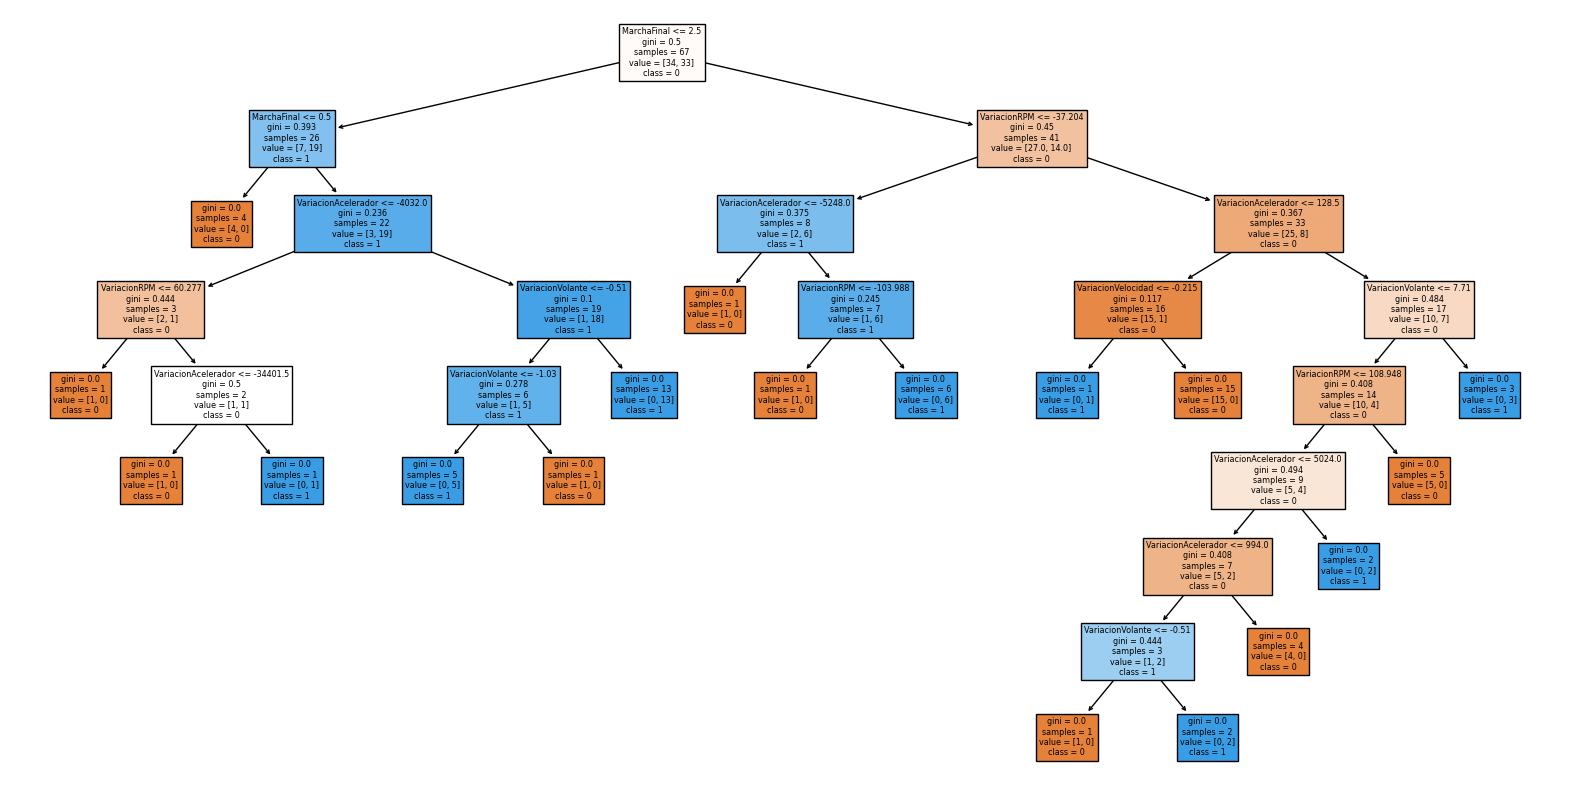

In [3]:
# Crear el objeto del árbol de decisión
clf = DecisionTreeClassifier(random_state=42)

# Entrenar el modelo del árbol de decisión
clf = clf.fit(X_train, y_train)

# Predecir las respuestas para el conjunto de datos de prueba
y_pred = clf.predict(X_test)

# Calcular la precisión del modelo
print("Precisión:", metrics.accuracy_score(y_test, y_pred))

# Visualizar el árbol de decisión
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=["VariacionVolante", "VariacionAcelerador", "VariacionFreno", "VariacionEmbrague", "VariacionVelocidad", "VariacionRPM", "MarchaInicio", "MarchaFinal"], class_names=['0', '1'])
plt.show()

Se procede al análisis del árbol:

Las caracterísitcas de los nodos del árbol son las siguientes:

* Condición: Se refiere a una condición que se basa en una característica del conjunto de datos, pues cada nodo es un punto de decisión donde el árbol pregunta si los datos cumplen con cierto criterio relacionado con una característica. Por ejemplo, en el nodo raíz se pregunta sobre MarchaFinal <= 2,5. Dependiendo de si es True o False el árbol guiará la muestra por la izquerda o por la derecha respetivamente para llegar al siguiente nodo. 

* Gini: El coeficiente de Gini se utiliza para cuantificar la pureza de un nodo. Un coeficiente de Gini de 0 indica que todas las muestras en el nodo pertenecen a una sola clase, mientras que un valor mayor indica una mezcla de clases.

* Muestras: Este número indica cuántas muestras del conjunto de datos procesa un nodo.

* Valor: Representa un vector con 2 valores que indican cuántas muestras pertenecen a cada clase.

* Clase: La clase que se predice(0 o 1, se hace la maniobra o no) si la muestra llega a este nodo y no hay más divisiones (en caso de que sea un nodo hoja).

* Nodos Hijos: Después del nodo raíz, el árbol se divide en dos nodos hijos. Cada uno de estos nodos representa una respuesta a la pregunta formulada en el nodo raíz.

Para saber qué eventos son característicos de la maniobra de adelantamiento es importante observar aquellos nodos finales con un valor de 'clase' igual a 1. De esta manera, se pueden establecer caminos cuyas condiciones se identifiquen con la maniobra analizada.

Por ejemplo, para el nodo final más a la derecha:

* Nivel 0: Estar en una marcha alta (MarchaFinal > 2.5).

* Nivel 1: Mantener o incrementar las RPM (VariacionRPM > -37.20).

* Nivel 2: Un aumento significativo en la presión del acelerador (VariacionAcelerador > 128.50).

* Nivel 3: Un cambio sustancial en el ángulo del volante hacia una dirección específica (VariacionVolante > 7.71).

* Nivel 4: El nodo perteneciente a la clase 1, correspondiente a un adelantamiento, al que se ha llegado según estas condiciones.

## Support Vector Model

Las Máquinas de Vectores de Soporte son un enfoque de aprendizaje supervisado utilizado para la clasificación y regresión, al considerarse este problema uno de clasificación binaria, es maniobra o no, se ha considerado adecuado utilizarlo. 

La fortaleza de las SVM está en su capacidad para encontrar la mejor separación posible entre clases en un espacio de características, maximizando un margen entre los puntos de datos de diferentes clases. En el contexto de predecir si una situación de conducción implica una maniobra de adelantamiento o no, las SVM ofrecen ventajas significativas. 

Dada la complejidad inherente a la identificación precisa de tales maniobras, se considera a las SVM capaces de modelar de manera efectiva patrones en los datos de entrada. 

Además, la capacidad de las SVM para gestionar conjuntos de datos desbalanceados, comúnmente encontrados en problemas de clasificación de maniobras de conducción, garantiza un rendimiento robusto al abordar la variabilidad en la distribución de clases.

En primer lugar, generaremos un modelo SVM lineal con margen duro. Para lograr esto, estableceremos el parámetro C a un valor suficientemente alto. En el contexto de SVM, el parámetro C controla la penalización por las violaciones del margen. Cuando C es grande, indica una penalización fuerte por dichas violaciones. En otras palabras, el modelo SVM con margen duro se esfuerza por clasificar todas las muestras correctamente y mantener el margen lo más estrecho posible.

Este enfoque implica que el modelo buscará minimizar las violaciones del margen y, en consecuencia, tiende a tener pocos vectores de soporte. Los vectores de soporte son las instancias que determinan la posición y orientación del margen, y en un margen duro, el modelo se esfuerza por clasificar cada instancia correctamente, incluso si esto significa reducir el margen.

Precisión del modelo SVM (Margen Duro): 0.7666666666666667


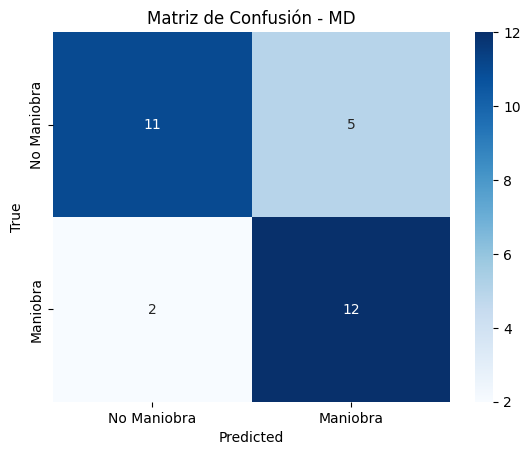

In [4]:
# SVM con margen duro
svm_md = SVC(kernel='linear', C=1e4, random_state=42)
svm_md.fit(X_train, y_train)
y_pred_md = svm_md.predict(X_test)
accuracy_md = metrics.accuracy_score(y_test, y_pred_md)
print("Precisión del modelo SVM (Margen Duro):", accuracy_md)

cm = confusion_matrix(y_test, y_pred_md)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['No Maniobra', 'Maniobra'], yticklabels=['No Maniobra', 'Maniobra'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión - MD')
plt.show()

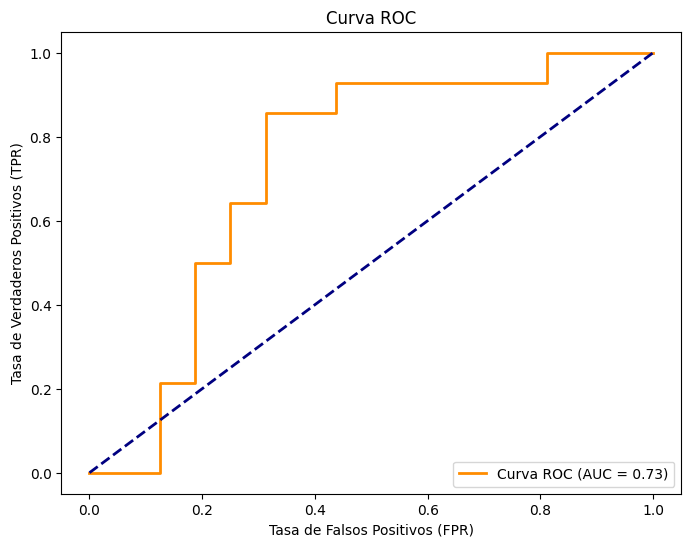

In [5]:
# Obtener las probabilidades de las predicciones
y_prob = svm_md.decision_function(X_test)
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# Calcular el área bajo la curva (AUC)
roc_auc = auc(fpr, tpr)
# Visualizar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

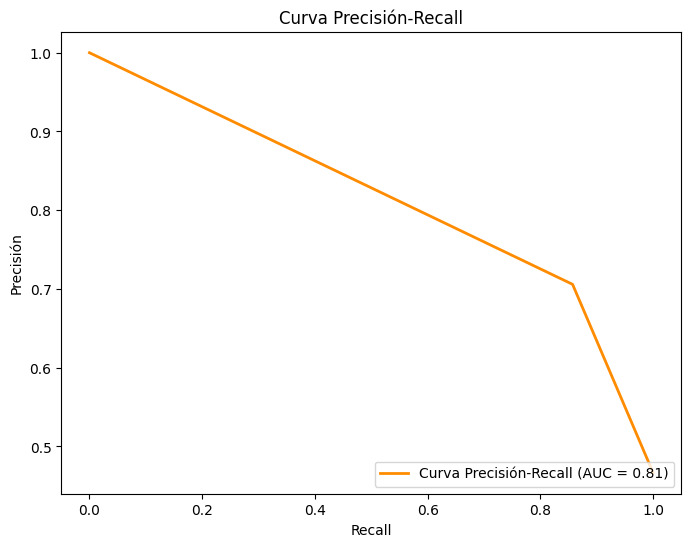

In [6]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_md)
auc_score = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='Curva Precisión-Recall (AUC = {:.2f})'.format(auc_score))
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva Precisión-Recall')
plt.legend(loc='lower right')
plt.show()

Con una precisión inicial de 0.76 y una AUC de la Curva ROC de 0.73, optaremos por aplicar un enfoque de SVM con margen blando para potencialmente mejorar estos parámetros.

Cuando nos referimos a la implementación de un enfoque de Margen Blando (MB), el objetivo es expandir el margen establecido por el modelo SVM lineal previo, el cual tenía un margen bastante estrecho. Para lograr un Margen Blando, reducimos el valor del parámetro C, lo que implica una penalización más indulgente ante las violaciones del margen. En otras palabras, el modelo SVM con margen blando permite cierto grado de incumplimientos del margen si esto contribuye a una mejor generalización del modelo.

Al disminuir C, los coeficientes asociados a las características se ven reducidos, resultando en la identificación de más instancias como vectores de soporte. Este aumento en el número de vectores de soporte amplía el margen. La premisa subyacente es que el modelo exhibirá un ajuste más apropiado de la frontera de separación, mejorando su capacidad para generalizar.

Incluso en escenarios donde la separación perfecta no es factible, el paradigma SVM se esfuerza por determinar la mejor línea divisoria posible, utilizando todas las instancias en la zona de contacto como vectores de soporte para lograr este ajuste.

Precisión del modelo SVM (Margen Blando): 0.7666666666666667


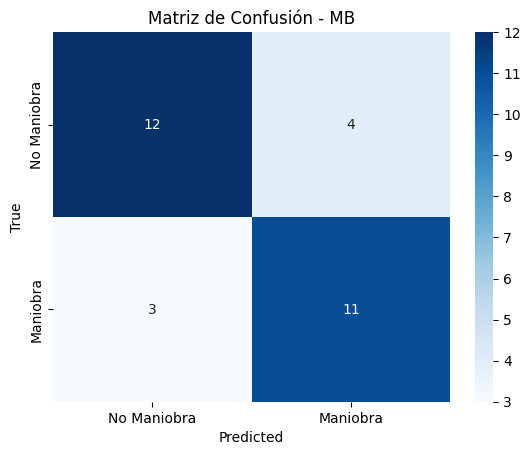

In [5]:
# SVM con margen blando
svm_mb = SVC(kernel='linear', C=0.1, random_state=42)
svm_mb.fit(X_train, y_train)
y_pred_mb = svm_mb.predict(X_test)
accuracy_mb = metrics.accuracy_score(y_test, y_pred_mb)
print("Precisión del modelo SVM (Margen Blando):", accuracy_mb)

cm = confusion_matrix(y_test, y_pred_mb)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['No Maniobra', 'Maniobra'], yticklabels=['No Maniobra', 'Maniobra'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión - MB')
plt.show()

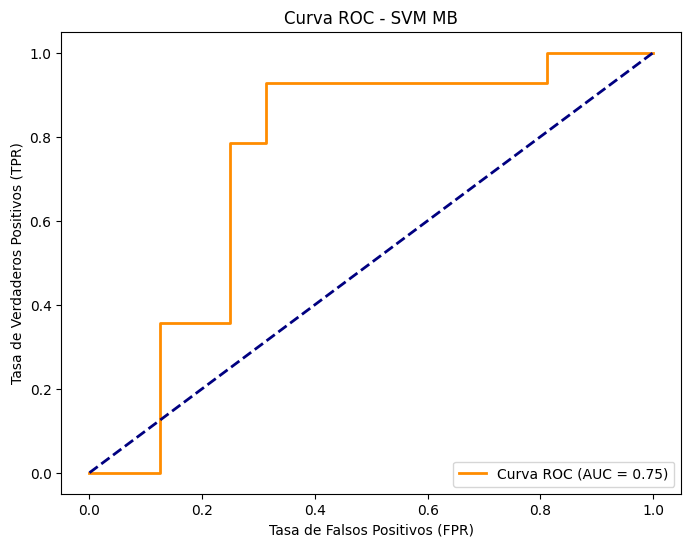

In [6]:
# Obtener las probabilidades de las predicciones
y_prob = svm_mb.decision_function(X_test)
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# Calcular el área bajo la curva (AUC)
roc_auc = auc(fpr, tpr)
# Visualizar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - SVM MB')
plt.legend(loc='lower right')
plt.show()

Comprobaremos que tenemos una precisión y un AUC de la curva ROC con valores muy similares a la versión anterior con margen duro. El AUC-ROC más alto sugiere que el modelo con margen blando es más efectivo para ajustar su sensibilidad y especificidad, mejorando la tasa de verdaderos positivos sin sacrificar significativamente la tasa de falsos positivos.
En este caso se considera el problema lineal, si no fuese así se aplicarían distintos kernels que variarían la manera de representar la frontera discriminante característica.


## Logistic Regression

La Regresión Logística puede considerarse como un método analítico crucial en el aprendizaje supervisado. Su aplicación abarca tanto problemas de clasificación binaria como múltiple, ofreciendo una herramienta robusta para modelar relaciones complejas entre características y etiquetas. En este contexto de predecir si una situación de conducción implica una maniobra de adelantamiento o no, la Regresión Logística puede ser un enfoque pertinente y efectivo.

La adaptabilidad de la Regresión Logística a la modelación de relaciones lineales y no lineales permite capturar la variabilidad en los datos de entrada asociados con diferentes clases de maniobras de conducción. Además, su capacidad para proporcionar probabilidades de pertenencia a una clase específica facilita la interpretación de los resultados. En el caso de tener conjuntos de datos desbalanceados, un fenómeno frecuente en la clasificación de maniobras de conducción, la Regresión Logística demuestra una capacidad robusta para ofrecer predicciones precisas y equilibradas. Así, la Regresión Logística se postula como una elección prudente y efectiva para abordar la tarea de clasificación en el contexto de la conducción vehicular.

In [9]:
from sklearn.linear_model import LogisticRegression

# Creamos el clasificador de regresión logística
# Max_iter de por defecto
logreg_classifier = LogisticRegression(max_iter=10000, random_state=42)

# Entrenamos el modelo de regresión logística
logreg_classifier.fit(X_train, y_train)

# Predecimos las etiquetas para el conjunto de prueba
y_pred_logreg = logreg_classifier.predict(X_test)

# Evaluamos la precisión del modelo de regresión logística
accuracy_logreg = metrics.accuracy_score(y_test, y_pred_logreg)
print("Precisión del modelo de Regresión Logística:", accuracy_logreg)

Precisión del modelo de Regresión Logística: 0.8


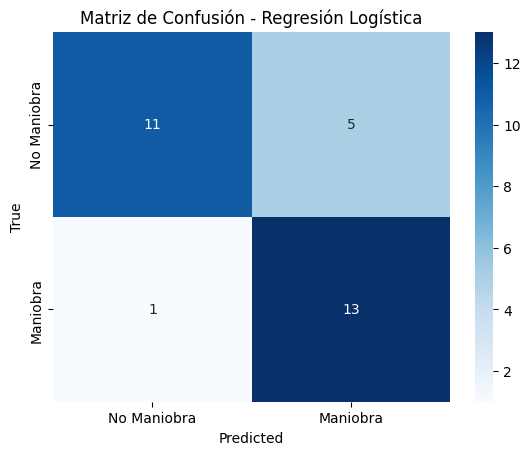

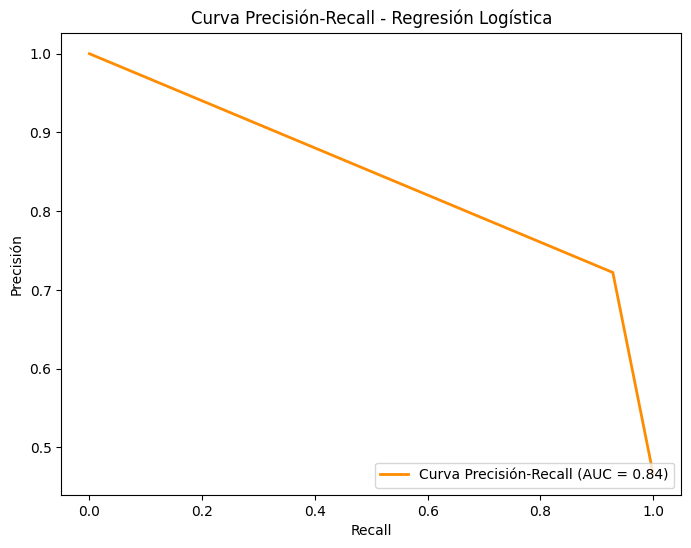

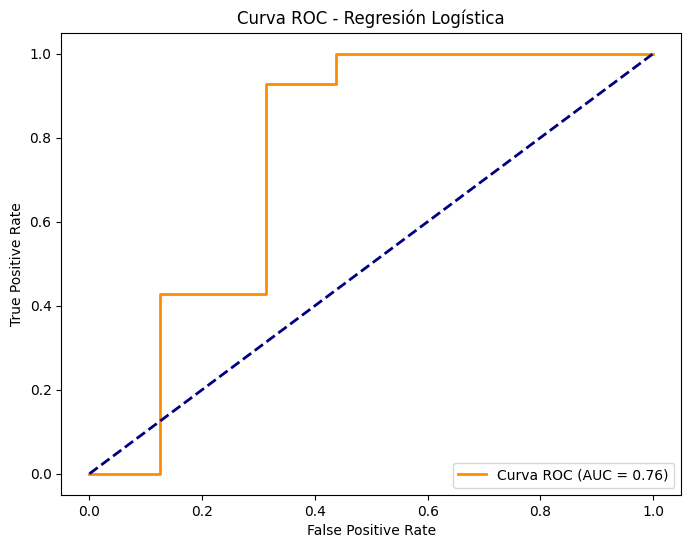

In [10]:
# Matriz de confusión
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm_logreg, annot=True, fmt='g', cmap='Blues', xticklabels=['No Maniobra', 'Maniobra'], yticklabels=['No Maniobra', 'Maniobra'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

# Visualizar la curva Precisión-Recall para el modelo de regresión logística
precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, y_pred_logreg)
auc_score_logreg = auc(recall_logreg, precision_logreg)

plt.figure(figsize=(8, 6))
plt.plot(recall_logreg, precision_logreg, color='darkorange', lw=2, label='Curva Precisión-Recall (AUC = {:.2f})'.format(auc_score_logreg))
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva Precisión-Recall - Regresión Logística')
plt.legend(loc='lower right')
plt.show()

# Obtener las probabilidades de predicción para la clase positiva
y_prob_logreg = logreg_classifier.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logreg)
roc_auc = auc(fpr, tpr)

# Visualizar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')
plt.show()

Los valores que vemos en las gráficas y resultados anteriores son mejores tanto a los valores obtenidos con el Árbol de Decisión como el SVM linear, esto podría deberse a diversas razones, pero primordialmente a su baja sensibilidad a outliers y a su alta eficiencia con problemas cuasi-lineales.

## Red Neuronal

Implementación de red neuronal multicapa para clasificación. Tolerante al ruido , proclive al sobreajuste y costoso de entrenar. Multilayer Perceptron

Tras diversos ajustes en los parámetros del clasificador de la red neuronal se decide aplicar la siguiente configuración.

Precisión del modelo de Red Neuronal: 0.6333333333333333


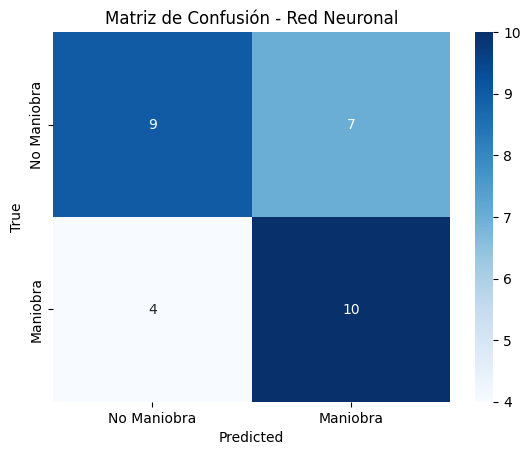

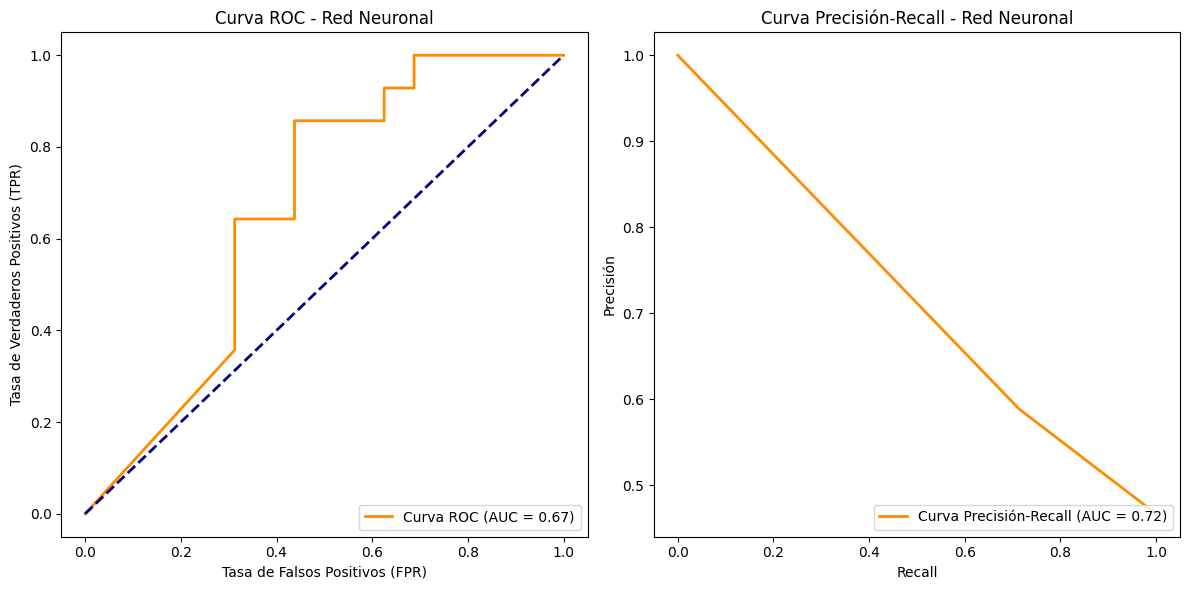

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, roc_auc_score

nn_classifier = MLPClassifier(
    hidden_layer_sizes=(50,),   # simplificación para evitar sobreajuste
    activation='relu',
    solver='adam',
    alpha=0.0001, # añadimos un término de regularización para penalizar coeficientes grandes
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001, # al ser la tasa de aprendizaje baja el modelo podría converjer mejor
    max_iter=200, # aumentado para permitir más tiempo de entrenamiento y convergencia
    shuffle=True,
    random_state=42,
    tol=1e-4,
    verbose=False,
    early_stopping=False # deshabilidato para permitir al modelo completar las iteraciones
)

# Entrenar
nn_classifier.fit(X_train, y_train)
# Predecir
y_pred_nn = nn_classifier.predict(X_test)

# Evaluar 
accuracy_nn = metrics.accuracy_score(y_test, y_pred_nn)
print("Precisión del modelo de Red Neuronal:", accuracy_nn)

# Matriz de confusión
cm_nn = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm_nn, annot=True, fmt='g', cmap='Blues', xticklabels=['No Maniobra', 'Maniobra'], yticklabels=['No Maniobra', 'Maniobra'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión - Red Neuronal')
plt.show()

# Visualización
precision_nn, recall_nn, _ = precision_recall_curve(y_test, y_pred_nn)
auc_score_nn = auc(recall_nn, precision_nn)

plt.figure(figsize=(12, 6))

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, nn_classifier.predict_proba(X_test)[:, 1])
roc_auc = roc_auc_score(y_test, nn_classifier.predict_proba(X_test)[:, 1])
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Red Neuronal')
plt.legend(loc='lower right')

# Curva Precisión-Recall
plt.subplot(1, 2, 2)
plt.plot(recall_nn, precision_nn, color='darkorange', lw=2, label='Curva Precisión-Recall (AUC = {:.2f})'.format(auc_score_nn))
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva Precisión-Recall - Red Neuronal')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

A pesar de ajustar el modelo para encontrar un equilibrio la precisión que se obtiene es muy baja, así como el resto de valores visualizados.

Se podría deducir que no se adecua bien a la naturaleza del problema, y puede ser propenso al sobreajuste, ya que en comparación tanto los modelos de SVM como del Árbol de Decisión dan mejores resultados.



# Conclusiones

En este estudio comparativo de modelos de aprendizaje automático para la predicción de maniobras de adelantamiento, se observó que el Logistic Regression superó a otras opciones, logrando la mejor precisión en la clasificación. Sin embargo, se identificaron desafíos en el preprocesado de datos que podrían afectar el rendimiento general del modelo. La estrategia de combinar datos en conjuntos de un segundo puede haber introducido granularidad excesiva, y la decisión de considerar solo el primer segundo de cada maniobra podría haber simplificado demasiado el problema. Estos aspectos podrían requerir una revisión más detallada para garantizar que se capturen patrones más sutiles y se evite la pérdida de información relevante.

Se destacó la importancia de una cuidadosa selección de características y la exploración de diferentes técnicas de preprocesamiento. La comparación entre datos procesados y datos brutos sugiere la necesidad de analizar más a fondo qué características específicas contribuyen de manera más significativa a la predicción. Además, se sugiere una evaluación más profunda de los parámetros del modelo y la consideración de algoritmos adicionales para mejorar aún más el rendimiento del modelo. Si bien el Logistic Regression se destacó, se reconoce la necesidad de seguir explorando ajustes y enfoques alternativos para abordar los desafíos específicos presentes en el conjunto de datos y en el problema de predicción de maniobras de adelantamiento.